# MOLEARN ANALYSIS TUTORIAL

This tutorial is dedicated to demonstrating how to use the  neural network [molearn]() after it is trained, and how to characterize its performance. molearn is described in [ V.K. Ramaswamy et al. (2021). *Learning protein conformational space with convolutions and latent interpolations*, Physical Review X 11](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.011052). To get started, let's load some packages!

In [1]:
import sys, os, glob
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import modeller
from modeller import *
from modeller.scripts import complete_pdb

import biobox as bb

#edit path as required for your computer (or remove, if you installed molearn via conta-forge)
sys.path.insert(0, "C:\\Users\\xdzl45\\workspace\\molearn\\src")
from molearn import load_data, Auto_potential, Autoencoder, ResidualBlock

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### 1. Load neural network and training set

Let's start by defining neural network file (variable `networkfile`, holding the parameters of a trained neural network), training set (variable `training_set_file`), and test set (variable `test_set_file`).

In [82]:
networkfile = "C:\\temp\\Dropbox\\Durham\\data\\neural_net\\conv1d-physics-path_B.pth"
training_set_file = "MurD_closed_open_strided.pdb"
test_set_file = "MurD_closed_apo_strided.pdb"

We will now load the training set, making sure to extract from it only the atoms actually used during training (CA, C, N, O, CB). This yields:
 - `training_set`, a data structure containing a desired subset of normalized atomic coordinates ready for submission to the neural network.
 - `meanval` and `stdval`, the mean and standard deviation of the original input data, useful to rescale generated structures
 - `atom_names` list containing the names of atoms in the training set (in the same order)
 - `mol`, a  `biobox` instance corresponding to the coordinates in `training_set`, useful as a PDB writer and offering useful helper functions, e.g. RMSD calculation.
 - `test0` and `test1`, `biobox` instances of the two most extreme conformations by RMSD in the loaded dataset.

In [83]:
training_set, meanval, stdval, atom_names, mol, test0, test1 = load_data(training_set_file, atoms = ["CA", "C", "N", "CB", "O"], device=device)
os.remove("rmsd_matrix.npy") # needed to prevent loading of incorrect distance matrix calculated for training set

Getting rmsd from file:  rmsd_matrix.npy
rmsd_from_file: rmsd_matrix.npy is not a valid filename or doesnt exist
rmsd not found therefore I have to calculate it
rmsd calcs Done
Conformations: (also saved to dataset_conformations.npy)
[]


`training_set` takes the form of a Nx3xM normalised `Tensor` object, where N is the number of examples and M the number of atoms, and 3 the x, y, z coordinates of each atom. This is the order of dimensions required by the neural network, a typical multiPDB has columns in the NxMx3 order.

In [86]:
print(training_set.shape)

torch.Size([380, 3, 2145])


Let's now load a test set, but this time let's only retain the coordinates of atoms, normalised and ready to be submitted to the neural network. The test set must contain the same atoms as the training set, in the same order. The two datasets should also be aligned, since *molearn* is not rototranslation invariant (yet).

In [89]:
test_set = load_data(test_set_file, atoms = ["CA", "C", "N", "CB", "O"], device=device)[0]
os.remove("rmsd_matrix.npy")

Getting rmsd from file:  rmsd_matrix.npy
rmsd_from_file: rmsd_matrix.npy is not a valid filename or doesnt exist
rmsd not found therefore I have to calculate it
rmsd calcs Done
Conformations: (also saved to dataset_conformations.npy)
[]


We can now load the trained network. Note that the parameters passed to the `Autoencoder` costructor need to be the same as those used to build the trained neural network.

In [90]:
checkpoint = torch.load(networkfile, map_location=device)
network = Autoencoder(m=2.0, latent_z=2, r=2).to(device)
network.load_state_dict(checkpoint['model_state_dict'])

for modulelist in [network.encoder, network.decoder]:
    for layer in modulelist:
        if type(layer)==torch.nn.BatchNorm1d:
            layer.momentum=1.0
        elif type(layer)==ResidualBlock:
            for rlayer in layer.conv_block:
                if type(rlayer)==torch.nn.BatchNorm1d:
                    rlayer.momentum=1.0
                    
with torch.no_grad():
    network.decode(network.encode(training_set.float()))

network.eval()

Autoencoder(
  (encoder): ModuleList(
    (0): Conv1d(3, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (4): BatchNorm1d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
      )
    )
    (7): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=

### 2. Projection into latent space and back

Let's start by projecting the whole training set into the latent space.

In [91]:
with torch.no_grad():
    z = network.encode(training_set.float())

`z` is a (Nx2x1) `Tensor` object, featuring the projection in the latent space of each of the N examples in the training set. If this notebook is running with a computer with a GPU, it will be stored in its memory. To get the data so we can plot it, we should move it back to the CPU, and remove one dimension.

In [92]:
z_training = z.data.cpu().numpy()[:, :, 0]

`z` can be decoded back into structures that, hopefully, will closely resemble the training set. Note that we clip the output to the size of dataset's degrees of freedom (an extra padding is present).

In [93]:
with torch.no_grad():  
    decoded_training = network.decode(z)[:, :, :training_set.shape[2]]

`decoded_training` is a now `Tensor` object stored in the GPU with the same dimensionality as the input `training_set`, and features normalised atomic coordinates. While it can already be directly compared with `training_set`, to obtain an actual protein structure we can observe, we should reorder the columns, move the data onto the CPU and "un-normalise" them.

In [94]:
decoded_protein = decoded_training[:, :, :training_set.shape[2]].data.cpu().numpy().transpose(0, 2, 1)
print(decoded_protein.shape)

(380, 2145, 3)


Ok, now let's repeat encoding and decoding with the test set!

In [95]:
with torch.no_grad():
    z = network.encode(test_set.float())
    z_test = z.data.cpu().numpy()[:, :, 0]
    decoded_test = network.decode(z)[:, :, :test_set.shape[2]]

### 2. dataset analysis

#### 2.2. RMSD (or MSE) of input vs autoencoded

A way to evaluate the performance of the network, is to compare protein conformations before they are submitted to the neural network, and after they get encoded and decoded. Please note that reporting such results for the training set only is poor practice, an independent test set should be submitted to evaluate the ability of the network to generalize beyond the examples provided for training. Let's calculate the MSE of both training and test sets!

In [96]:
def get_error(network, dataset, meanval, stdval, align=False, mol=""):
    '''
    Calculate the reconstruction error of a dataset encoded and decoded by a trained neural network
    '''

    z = network.encode(dataset.float())
    decoded = network.decode(z)[:,:,:dataset.shape[2]]
    
    err = []
    for i in range(dataset.shape[0]):

        crd_ref = dataset[i].permute(1,0).unsqueeze(0).data.cpu().numpy()*stdval + meanval
        crd_mdl = decoded[i].permute(1,0).unsqueeze(0).data.cpu().numpy()[:, :dataset.shape[2]]*stdval + meanval #clip the padding of models  

        if align: # use Molecule Biobox class to calculate RMSD
            mol.coordinates = deepcopy(crd_ref)
            mol.set_current(0)
            mol.add_xyz(crd_mdl[0])
            rmsd = mol.rmsd(0, 1)
        else:
            rmsd = np.sqrt(np.sum((crd_ref.flatten()-crd_mdl.flatten())**2)/crd_mdl.shape[1]) # Cartesian L2 norm

        err.append(rmsd)

    return np.array(err)
    
rmsd_training = get_error(network, training_set, meanval, stdval)
rmsd_test = get_error(network, test_set, meanval, stdval)

Time to produce two nice violin plots, reporting on the error of training and test set. Typically the latter should be slightly worse than the former, though ideally this difference should be as small as possible, indicating that the neural network can generalize well to structures it has never seen.

In [97]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.violinplot([rmsd_training, rmsd_test], showmeans=True)
ax.set_ylabel("RMSD / $\AA$")
ax.set_xticks([1, 2])
ax.set_xticklabels(["training set", "test set"]);

#### 2.3. DOPE score of input vs autoencoded

The DOPE score is a heuristic function used to estimate the energy of a protein conformation. It is used by software like Modeller to define whether a protein model is accurate. Here, we start by defining a function calculating the DOPE score of a PDB file.

In [98]:
def dope_score(fname):
    env = Environ()
    env.libs.topology.read(file='$(LIB)/top_heav.lib')
    env.libs.parameters.read(file='$(LIB)/par.lib')
    mdl = complete_pdb(env, fname)
    atmsel = Selection(mdl.chains[0])
    score = atmsel.assess_dope()
    return score

A positive value for a DOPE score indicates that the distriution of atoms is not what one should expect from a correct protein conformation. However, just looking at a negative value it is hard to tell "how good it is". To tell whether the models generated by the neural network are good, we will compare their DOPE score with the DOPE score of the input dataset. We now calculate the DOPE score of the training and test sets.

In [102]:
def get_dope(network, dataset, meanval, stdval, mol):
    
    # set residues names with protonated histidines back to generic HIS name (needed by DOPE score function)
    testH = mol.data["resname"].values
    testH[testH == "HIE"] = "HIS"
    testH[testH == "HID"] = "HIS"
    mol.data["resname"] = testH

    z = network.encode(dataset.float())
    decoded = network.decode(z)[:,:,:dataset.shape[2]]
    
    dope_dataset = []
    dope_decoded = []
    for i in range(dataset.shape[0]):

        # calculate DOPE score of input dataset
        crd_ref = dataset[i].permute(1,0).unsqueeze(0).data.cpu().numpy()*stdval + meanval
        mol.coordinates = deepcopy(crd_ref)
        mol.write_pdb("tmp.pdb")
        s = dope_score("tmp.pdb")
        dope_dataset.append(s)

        # calculate DOPE score of decoded counterpart
        crd_mdl = decoded[i].permute(1,0).unsqueeze(0).data.cpu().numpy()[:, :dataset.shape[2]]*stdval + meanval  
        mol.coordinates = deepcopy(crd_mdl)
        mol.write_pdb("tmp.pdb")
        s = dope_score("tmp.pdb")
        dope_decoded.append(s)
    
    return dope_dataset, dope_decoded
 
dope_training, dope_training_decoded = get_dope(network, training_set, meanval, stdval, mol)
dope_test, dope_test_decoded = get_dope(network, test_set, meanval, stdval, mol)

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   671085
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633289
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   661612
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631688
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   660504
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637769
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   655127
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639765
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   658761
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643371
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   655500
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643096
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   662190
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641711
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   658046
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642012
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   663599
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640992
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   660194
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644575
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   656733
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642901
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   652783
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643124
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   658509
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641458
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   660084
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641970
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   657842
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642944
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   669991
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643438
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   663059
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643101
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   660840
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640871
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   659755
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642781
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   655197
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640029
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

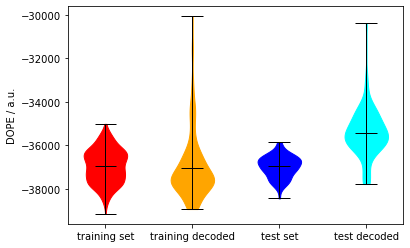

In [119]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
violins = ax.violinplot([dope_training, dope_training_decoded, dope_test, dope_test_decoded],
                        showmeans = True, showextrema = True)

ax.set_ylabel("DOPE / a.u.")
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["training set", "training decoded", "test set", "test decoded"]);

colours=["red", "orange", "blue", "cyan"]
for i, violin in enumerate(violins['bodies']):
    violin.set_color(colours[i])
    violin.set_alpha(1)

for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violins[partname]
    vp.set_edgecolor("k")
    vp.set_linewidth(1)

### 4. full latent space characterization

In this section, we will grid sample the latent space. To this end, we start by identifying the region of interest defined by the coordinates of the training set projected into the latent space.

In [124]:
samples = 50
bx = (np.max(z_training[:, 0]) - np.min(z_training[:, 0]))*0.1 # 10% margins on x-axis
by = (np.max(z_training[:, 1]) - np.min(z_training[:, 1]))*0.1 # 10% margins on y-axis
xvals = np.linspace(np.min(z_training[:, 0])-bx, np.max(z_training[:, 0])+bx, samples)
yvals = np.linspace(np.min(z_training[:, 1])-by, np.max(z_training[:, 1])+by, samples)

<div class="alert alert-block alert-warning">
<b>Warning:</b> depending on the sampling granularity, this operation can take a *long* time! Calculating the DOPE score of a 50x50 grid can take ~20 minutes. 
</div>

#### 4.1. Evaluate re-encoding error

Each position in the latent space is decoded, then encoded, the decoded yet again. We assess the drift in latent space upon this iteration and the difference in two consecutive decoded structures with an L2 norm. This acts as a heuristic for the accuracy of the neural network: the smaller these numbers, the more accurate the network. 

In [125]:
surf_z = np.zeros((len(xvals), len(yvals))) # L2 norms in latent space ("drift")
surf_c = np.zeros((len(xvals), len(yvals))) # L2 norms in Cartesian space

with torch.no_grad():
    
    for x, i in enumerate(xvals):
        for y, j in enumerate(yvals):
    
            # take latent space coordinate (1) and decode it (2)
            z1 = torch.tensor([[[i,j]]]).float()
            s1 = network.decode(z1)[:,:,:training_set.shape[2]]
            
            # take the decoded structure, re-encode it (3) and then decode it (4)
            z2 = network.encode(s1)
            s2 = network.decode(z2)[:,:,:training_set.shape[2]]
            
            surf_z[x,y] = np.sum((z2.numpy().flatten()-z1.numpy().flatten())**2) # Latent space L2, i.e. (1) vs (3)
            surf_c[x,y] = np.sum((s2.numpy().flatten()-s1.numpy().flatten())**2) # Cartesian L2, i.e. (2) vs (4)
            
surf_c = np.sqrt(surf_c)
surf_z = np.sqrt(surf_z)

Plot error surfaces for L2 norms in the latent and Cartesian space, and compare the two. For visualisation purposes, we take the log of both quantities.

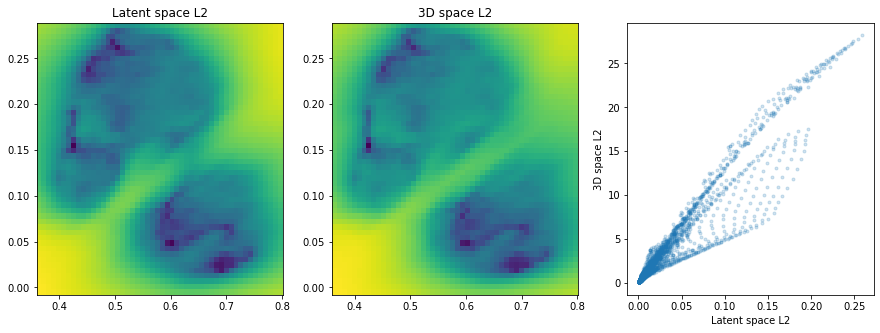

In [126]:
X, Y = np.meshgrid(xvals, yvals)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.set_title("Latent space L2")
ax.pcolormesh(X, Y, np.log(surf_z))

ax = fig.add_subplot(1, 3, 2)
ax.set_title("3D space L2")
ax.pcolormesh(X, Y, np.log(surf_c))

ax = fig.add_subplot(1, 3, 3)
ax.set_xlabel("Latent space L2")
ax.set_ylabel("3D space L2")
ax.plot(surf_z.flatten(), surf_c.flatten(), ".", alpha=0.2);

You will notice that, although in general large drift corresponds to large RMSD, there is not a 1:1 relationship between the two quantities. This is because the latent space is not linear: the same magnitude of displacement in two different regions of the latent space may be associated to displacements of different magnitude in the 3D space. You may see several trends, overlayed, if the neural network has been trained with a collection of different molecular dynamics simulations projecting in different regions of the latent space.

#### 4.2. Evaluate DOPE score

We will now calculate the DOPE score of every conformation decoded from the latent space.

In [127]:
surf_dope = np.zeros((len(xvals), len(yvals)))

with torch.no_grad():
    
    for x, i in enumerate(xvals):
        for y, j in enumerate(yvals):
    
            # take latent space coordinate (1) and decode it (2)
            z1 = torch.tensor([[[i,j]]]).float()
            s1 = network.decode(z1)[:,:,:training_set.shape[2]]
            
            crd_mdl = s1[0].permute(1,0).unsqueeze(0).data.cpu().numpy()[:, :training_set.shape[2]]*stdval + meanval  
            mol.coordinates = deepcopy(crd_mdl)
            mol.write_pdb("tmp.pdb")
            s = dope_score("tmp.pdb")
            surf_dope[x,y] = s

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  TYR:OXT  TYR
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  TYR:OXT  TYR
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  TYR:OXT  TYR
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MO

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MO



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3313    2498
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   555226
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MO

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of al

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3294    2920
Number of all, selected pseudo atoms           

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3292    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS       

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3290    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number 

>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3296    2797
Num

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints select



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3303     382
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):    98173
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  LYS:OXT  LYS
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  TYR:OXT  TYR
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MO

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MO

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MO

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3293    2859
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected re



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   623231
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2983
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   617065
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289    2978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                               

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289    2978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625403
D

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's featur

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  TYR:OXT  TYR
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  TYR:OXT  TYR
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MO

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MO

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences be

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3293    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected re



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3290    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   619360
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   613560
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636508
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636500
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    3001
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   621777
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    3001
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634097
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3294    2582
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   575916
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  TYR:OXT  TYR
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MO

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not rea

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3293    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected re



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3290    2859
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   601337
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   613797
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635217
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632465
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633514
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640886
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   654981
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  TYR:OXT  TYR
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MO



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3298    2498
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   539399
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3293    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   586125
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   618695
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637477
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633231
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630753
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631055
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636023
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647775
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  TYR:OXT  TYR
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic o

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3295 



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   583360
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642066
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635195
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631479
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629830
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630645
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634601
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644618
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  TYR:OXT  TYR
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MO

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3294    2480
Number of all, selected pseudo atoms           



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   585419
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   618942
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636965
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631983
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630128
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629922
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631595
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636059
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   649390
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3293    2480
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected re

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3290    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number 

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645291
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637608
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632395
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630182
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630296
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630602
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633487
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641991
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3294    2314
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   485092
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3290    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   646383
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638630
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632530
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630553
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630549
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630572
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632198
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637070
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2498
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2962
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626391
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   646435
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638534
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632528
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630871
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630720
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630649
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631938
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635831
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2498
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   537496
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   652521
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   646557
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638559
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632515
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631196
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630779
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630919
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631963
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635088
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2498
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   536603
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   652506
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647265
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639238
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632635
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631427
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630779
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631085
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631992
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634494
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   659588
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   651718
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647589
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640887
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633362
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631657
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630938
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630840
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631996
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634072
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   657693
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   650034
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647871
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642776
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634813
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631940
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631223
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630794
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632121
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634040
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   655605
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   648299
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647684
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644655
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636372
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632484
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631669
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630935
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632175
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634220
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   653300
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   646168
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   646958
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645794
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638358
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633420
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632352
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631154
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632094
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634581
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   650681
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644237
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645848
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   646453
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640367
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635064
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632630
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631515
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632062
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634871
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647763
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642527
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644504
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   646358
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641924
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636233
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632752
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631889
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632123
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635129
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645311
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640390
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642939
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645813
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643118
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637393
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633060
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632283
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632355
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635221
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643048
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638904
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641201
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644735
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643724
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638949
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633655
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632803
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632786
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635655
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641848
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637900
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640127
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643667
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644309
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640022
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634647
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632918
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633270
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635976
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641071
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636841
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639412
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642945
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644333
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640712
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635426
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633040
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633867
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636262
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   597464
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636449
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638795
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641987
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643507
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641063
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636534
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633634
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634545
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636561
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   597627
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636247
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638528
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641050
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642360
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641068
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637571
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634575
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634962
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637294
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   597403
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636181
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638379
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640458
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641637
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640834
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638392
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635602
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635371
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637917
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   597529
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635977
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638408
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640528
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640981
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640502
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639348
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636954
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636019
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638151
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   597157
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635718
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638489
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641372
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640418
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640380
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640131
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638071
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637291
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639110
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   597308
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635957
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638531
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642010
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639973
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639745
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640158
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639168
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638432
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640321
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   597266
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636076
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638055
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641612
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639434
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639199
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639933
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640198
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639681
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641096
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   597725
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636536
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637576
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640082
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638562
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638775
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639789
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640915
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640928
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641791
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   598346
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636850
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636760
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637556
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637693
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638165
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639831
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641326
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642362
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642773
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   598872
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636823
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635745
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634901
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636719
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638026
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640144
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641601
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643254
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644010
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   599398
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636911
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634517
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633429
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635642
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638139
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640362
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642190
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643962
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645359
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   599971
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637000
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633645
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633076
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635247
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638346
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641086
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642932
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644830
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   646685
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   600696
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636575
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633109
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632912
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634858
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638449
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642387
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643971
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   646027
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647929
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   601222
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636086
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632454
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633041
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634717
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638521
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643113
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645080
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647708
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   649603
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   602103
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636230
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632321
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633074
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634925
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638456
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643140
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   646142
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   649257
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   651109
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   603184
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636969
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632469
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633279
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635166
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638409
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643076
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647168
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   650876
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   652817
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   603967
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638443
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633278
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633398
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635457
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638950
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643363
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   648296
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   652474
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   655261
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2832
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   605366
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640115
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634451
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633578
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635685
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639576
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643701
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   649406
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   653976
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   658153
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2717
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   581667
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641270
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635469
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634008
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636029
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640087
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644355
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   650369
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   655605
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2606
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                  

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2717
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   583393
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642468
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635911
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634748
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636162
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640227
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644605
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   651403
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   657259
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2606
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                  



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289    1294
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   302542
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643634
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635927
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635373
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636402
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640154
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644839
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   652225
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   659247
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2606
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                  

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289    1294
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   302511
D

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645244
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636329
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635522
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636703
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640154
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644937
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   652617
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   661135
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289     978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                               

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3293    1294
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected re

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   650307
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637875
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635440
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636915
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638770
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643444
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   651744
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2570
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (exc

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289     978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                               

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2717
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   585959
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643544
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636570
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637589
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638159
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640729
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   648539
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2570
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   558445
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289     978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                               

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289    2717
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   585744
D

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644542
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637583
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638783
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638946
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642744
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   651182
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2570
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   561430
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL     

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3290    2717
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number 

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2889
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   606553
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639396
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639887
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640848
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645460
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   654991
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3292     963
Number of all, s

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ILE:OXT  ILE
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MO

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not rea

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3290    2717
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number 

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2889
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   606178
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641376
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641824
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643928
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287     978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   243141
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291     963
Number of all, selected pseudo atoms              :        0       0
Nu

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  ILE:OXT  ILE
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LYS:OXT  LYS
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MO



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3309     978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   251430
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3293     978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected re

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289    2717
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   578966
D

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644958
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643522
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287     978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   241038
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289     963
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   240460
D

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL     

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  ILE:OXT  ILE
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  ILE:OXT  ILE
iatmcls_286W> MODEL atom not classified:



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3318     213
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):    71298
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ILE:OXT  ILE
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:

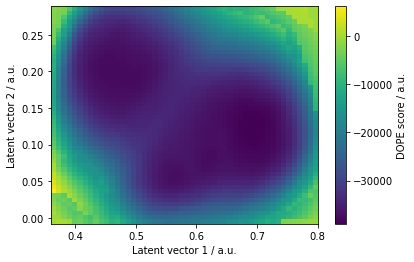

In [142]:
x, y = np.meshgrid(xvals, yvals)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Latent vector 1 / a.u.")
ax.set_ylabel("Latent vector 2 / a.u.")
c = ax.pcolormesh(x, y, surf_dope.T)
cbar = fig.colorbar(c, ax=ax)
cbar.set_label("DOPE score / a.u.");

***

## 5. Display data via interactive plot

Let's start by defining some helper functions!

In [129]:
def oversample(crd, pts=10):
    '''
    add extra equally spaced points between a list of points ("pts" per interval)
    ''' 
    pts += 1
    steps = np.linspace(1./pts, 1, pts)
    pts = [crd[0,0]]
    for i in range(1, len(crd[0])):
        for j in steps:
            newpt = crd[0, i-1] + (crd[0, i]-crd[0, i-1])*j
            pts.append(newpt)
    
    return np.array([pts])

def generate(network, crd, stdval, meanval):
    '''
    generate a collection of protein conformations, given (Nx2) coordinates in the latent space
    ''' 
    with torch.no_grad():
        z = torch.tensor(crd.transpose(1, 2, 0)).float()   
        s = network.decode(z)[:, :, :training_set.shape[2]].numpy().transpose(0, 2, 1)
    
    return s*stdval + meanval

The big block of code that follows is a graphical user interface to navigate the landscape of the neural network (work in progress).

In [138]:
from ipywidgets import HBox, VBox, Layout
from ipywidgets import widgets
from tkinter import Tk, filedialog
import plotly.graph_objects as go
import nglview as nv
import warnings
warnings.filterwarnings("ignore")
import time

# create an MDAnalysis instance of input protein
import MDAnalysis as mda
mol.write_pdb("tmp.pdb")
mymol = mda.Universe('tmp.pdb')

def on_click(trace, points, selector):
    '''
    control display of training set
    ''' 
    
    global waypoints
    
    # add new waypoint to list
    pt = np.array([[points.xs[0], points.ys[0]]])
    if len(waypoints) == 0:
        waypoints = pt    
    else:
        waypoints = np.concatenate((waypoints, pt))     

    # update latent space plot
    latent.data[3].x = waypoints[:, 0]
    latent.data[3].y = waypoints[:, 1]
    latent.update()

    # update textbox (triggering update of 3D representation)
    try:
        pt = np.array([latent.data[3].x, latent.data[3].y]).T.flatten().round(decimals=4).astype(str)
        mybox.value = " ".join(pt)
    except:
        return

def interact_3D(mybox, samplebox):
    '''
    generate and display proteins according to latent space trail
    ''' 
    
    # get latent space path
    try:
        crd = np.array(mybox.split()).astype(float)
        crd = crd.reshape((1, int(len(crd)/2), 2))       
        crd = oversample(crd, pts=int(samplebox))
    except:
        button_pdb.disabled = False
        return 
    
    # generate structures along path
    t = time.time()
    gen = generate(network, crd, stdval, meanval)
    print(f'{crd.shape[1]} struct. in {time.time()-t:.4f} sec.')
    
    # display generated structures
    mymol.load_new(gen)
    view = nv.show_mdanalysis(mymol)
    view.add_representation("spacefill")
    display(view)
    
    button_pdb.disabled = False

    
def drop_background_event(change):
    '''
    control colouring style of latent space surface
    '''
    
    global surf_c
    global surf_z
    global surf_dope
    
    state_choice = change.new
        
    if change.new == "drift":
        latent.data[0].z = np.log(surf_z).T
        latent.data[0].zmin = np.min(sz)
        latent.data[0].zmax = np.max(sz)
        block0.children[2].min = np.min(sz)
        block0.children[2].max = np.max(sz)
        block0.children[2].value = (np.min(sz), np.max(sz))
        block0.children[2].readout_format = '.1f'
        
    elif change.new == "RMSD":
        latent.data[0].z = np.log(surf_c).T
        latent.data[0].zmin = np.min(sc)
        latent.data[0].zmax = np.max(sc)
        block0.children[2].min = np.min(sc)
        block0.children[2].max = np.max(sc)
        block0.children[2].value = (np.min(sc), np.max(sc))
        block0.children[2].readout_format = '.1f'
        
    elif change.new == "DOPE":
        latent.data[0].z = surf_dope.T
        latent.data[0].zmin = np.min(surf_dope)
        latent.data[0].zmax = np.max(surf_dope)
        block0.children[2].min = np.min(surf_dope)
        block0.children[2].max = np.max(surf_dope)
        block0.children[2].value = (np.min(surf_dope), np.max(surf_dope))
        block0.children[2].readout_format = 'd'
    
    latent.update()


def check_training_event(change):
    '''
    control display of training set
    ''' 
    state_choice = change.new
    latent.data[1].visible = state_choice
    latent.update()


def check_test_event(change):
    '''
    control display of test set
    ''' 
    state_choice = change.new
    latent.data[2].visible = state_choice
    latent.update()

    
def range_slider_event(change):
    '''
    update surface colouring upon manipulation of range slider
    '''
    latent.data[0].zmin = change.new[0]
    latent.data[0].zmax = change.new[1]
    latent.update()
    

def mybox_event(change):
    '''
    control manual update of waypoints
    '''
    
    global waypoints
    
    try:
        crd = np.array(change.new.split()).astype(float)
        crd = crd.reshape((int(len(crd)/2), 2))
    except:
        button_pdb.disabled = False
        return
    
    waypoints = crd.copy()

    latent.data[3].x = waypoints[:, 0]
    latent.data[3].y = waypoints[:, 1]
    latent.update()
    
    
def button_pdb_event(check):
    '''
    save PDB file corresponding to the interpolation shown in the 3D view
    '''
    
    root = Tk()
    root.withdraw()                                        # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    fname = filedialog.asksaveasfilename(defaultextension="pdb", filetypes=[("PDB file", "pdb")])
    
    if fname == "":
        return
    
    crd = np.array(mybox.value.split()).astype(float)
    crd = crd.reshape((1, int(len(crd)/2), 2))       
    crd = oversample(crd, pts=int(samplebox.value))
    
    gen = generate(network, crd, stdval, meanval)
    mymol.load_new(gen)
    protein = mymol.select_atoms("all")

    with mda.Writer(fname, protein.n_atoms) as W:
        for ts in mymol.trajectory:
            W.write(protein)    


#####################################################

# collection of all saved waypoints
waypoints = []

# surface representation menu
drop_background = widgets.Dropdown(
    options=['drift', 'RMSD', 'DOPE'],
    value='drift',
    description='Surf.:',
    disabled=False, layout=Layout(flex='1 1 0%', width='auto'))

drop_background.observe(drop_background_event, names='value')

# training set visualisation menu
check_training = widgets.Checkbox(
    value=False,
    description='show training',
    disabled=False,
    indent=False, layout=Layout(flex='1 1 0%', width='auto'))

check_training.observe(check_training_event, names='value')

# test set visualisation menu
check_test = widgets.Checkbox(
    value=False,
    description='show test',
    disabled=False,
    indent=False, layout=Layout(flex='1 1 0%', width='auto'))

check_test.observe(check_test_event, names='value')


# text box holding current coordinates
mybox = widgets.Textarea(value='Welcome',
                         placeholder='coordinates',
                         description='crds:',
                         disabled=False, layout=Layout(flex='1 1 0%', width='auto'))

mybox.observe(mybox_event, names='value')

samplebox = widgets.Text(value='10',
                         description='sampling:',
                         disabled=False, layout=Layout(flex='1 1 0%', width='auto'))


button_pdb = widgets.Button(
    description='Save PDB',
    disabled=True, layout=Layout(flex='1 1 0%', width='auto'))

button_pdb.on_click(button_pdb_event)

sc = np.log(surf_c)
range_slider = widgets.FloatRangeSlider(
    value=[np.min(sc), np.max(sc)],
    min=np.min(sc),
    max=np.max(sc),
    step=(np.max(sc)-np.min(sc))/100.0,
    description='cmap range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f', layout=Layout(flex='1 1 0%', width='auto'))

range_slider.observe(range_slider_event, names='value')

### latent space plot ### 

# coloured background
plot1 = go.Heatmap(x=xvals, y=yvals, z=sc.T, zmin=np.min(sc), zmax=np.max(sc), colorscale='viridis', name="latent_space")   

# training set
plot2 = go.Scatter(x=z_training[:, 0], y=z_training[:, 1],
           showlegend=False, opacity=0.9, mode="markers",
           marker=dict(color='white', size=5), name="training", visible=False)
# test set
plot3 = go.Scatter(x=z_test[:, 0], y=z_test[:, 1],
           showlegend=False, opacity=0.9, mode="markers",
           marker=dict(color='silver', size=5), name="test", visible=False)

# path
plot4 = go.Scatter(x=np.array([]), y=np.array([]),
           showlegend=False, opacity=0.9,
           marker=dict(color='red', size=7))

latent = go.FigureWidget([plot1, plot2, plot3, plot4])
latent.update_layout(xaxis_title="latent vector 1", yaxis_title="latent vector 2",
                 autosize=True, width=400, height=350, margin=dict(l=75, r=0, t=25, b=0))
latent.update_xaxes(showspikes=False)
latent.update_yaxes(showspikes=False)

# 3D protein representation (triggered by update of textbox)
protein = widgets.interactive_output(interact_3D, {'mybox': mybox, 'samplebox': samplebox})

### arrange all widgets ###
block0 = widgets.VBox([check_training, check_test, range_slider, drop_background, samplebox, mybox, button_pdb],
                      layout=Layout(flex='1 1 2', width='auto', border="solid"))

block1 = widgets.VBox([latent], layout=Layout(flex='1 1 auto', width='auto'))
latent.data[0].on_click(on_click)

block2 = widgets.VBox([protein], layout=Layout(flex='1 5 auto', width='auto'))

scene = widgets.HBox([block0, block1, block2])
scene.layout.align_items = 'center'

display(scene)

***

# WORK IN PROGRESS

### Search best matching structure

We trained molearn with conformations of MurD in its closed and open state, and then wanted to see whether it could predict a suitable intermediate conformation. Before even attempting discovering that conformation (via a linear interpolation between open and closed conformation representatives), the question we can ask is: "*What is the best intermediate the neural network can generate?*". For that, we can search the latent space, looking to the region generating the best possible match vs a target (benchamark) intermediate.

In [66]:
from scipy.optimize import minimize

def latent(x):
   
    global network
    global stdval
    global meanval
    global crd_target
    
    crd_mdl = generate(network, np.array([[x]]), stdval, meanval)
    rmsd = np.sqrt(np.sum((crd_target.flatten()-crd_mdl.flatten())**2)/crd_mdl.shape[1])
    
    return rmsd
    
## target must be a Tensor representation of the structure to encode
## can be loaded with "load_data"
# test_set = load_data(test_set_file, atoms = ["CA", "C", "N", "CB", "O"], device=device)[0]
# here, we will just take a structure from the test set as example
target = test_set[0].unsqueeze(0) #target as normalized tensor
crd_target = target.permute(0, 2, 1).data.cpu().numpy()*stdval + meanval # target as 3D structure

# set initial guess as projection into latent space of target
with torch.no_grad():
    z = network.encode(target.float())
    z_test = z.data.cpu().numpy()[:, :, 0]

rmsd_init = latent(z_test[0])
print("init: %s -> %s"%(z_test[0], rmsd_init))

res = minimize(latent, x0=z_test)
print("best: %s -> %s"%(res.x, res.fun))

init: [0.6983468  0.06467382] -> 0.9434274832915155
best: [0.69834679 0.0656017 ] -> 0.942259399116219


### Iterative Autoencoding

The following function repeats and encode-decode cycle on a neural network, starting from a given target structure if a `Molecule` object is provided as parameter, saves and returns coordinates in a `Molecule` structure

In [ ]:
def loop_autoencoder(network, target, M=-1, iterations=5, verbose=False):
    
    inputsize = target.shape[1] #get number of atoms in target structure

    if not isinstance(M, int):
        #M: place where to store coordinates of generated models (preloading original structure)
        crds_ref = target.permute(1,0).unsqueeze(0).data.cpu().numpy()
        M.coordinates = crds_ref
        M.set_current(0)
    else:
        print("skipping molecule loading...")

    z_val = [] # storage space for latent space projections through iterations

    # encode, decode, re-encode, re-decode, re-re-encode, ... (n times)
    for i in range(iterations):

        # encode and decode (overwrite "target" for next iteration)
        with torch.no_grad():
            z = network.encode(target.unsqueeze(0).float())
            target = network.decode(z)[0,:,:training_set.shape[2]]

        # store latent space projection projection
        pos = z.data.cpu().numpy().flatten()
        z_val.append(pos)
        
        if verbose:
            print(i, pos)

        if not isinstance(M, int):
            # store generated structure upon request
            crds_ref = target.permute(1,0).unsqueeze(0).data.cpu().numpy()[0, :inputsize]
            M.add_xyz(crds_ref)

    if not isinstance(M, int):
        return M, z_val
    else:
        return z_val

Set a structure as starting point

In [ ]:
idx = 5 #index of structure
target = deepcopy(training_set[idx])

Loop network from that starting point (then rescaling all molecules coordinates)

In [ ]:
mol2, z_val = loop_autoencoder(network, target, mol, iterations=200)
mol2.coordinates *= stdval
mol2.coordinates += meanval

Iterate over all examples in training set and get paths followed by all

In [ ]:
iterations = 200
allz = []
d = deepcopy(training_set).float()
for i in range(iterations):
    with torch.no_grad():
        z = network.encode(d)
        d = network.decode(z)[:,:,:training_set.shape[2]]
        allz.append(z.numpy())
        
allz = np.array(allz)
allz = allz.reshape(iterations, training_set.shape[0], 2).transpose(1, 0, 2)

Analysis of autoencoding iteration of single structure

In [ ]:
z_val = np.array(z_val) #evolution of position in 2D latent space 
r_mat = mol2.rmsd_distance_matrix() # RMSD all-vs-all
r_dist = np.diagonal(r_mat, offset=1) #RMSD between consecutive iterations
z_dist = np.sqrt(np.sum((z_val[:-1]-z_val[1:])**2,axis=1)) # Euclidean distance in latent space of consecutive iterations
mol2.write_pdb("test.pdb") # evolution of molecular models through iterations

print("Step: ", len(z_dist) ,". Distance: ", z_dist[-1], ". RMSD: ", r_dist[-1])

In [ ]:
z_training = z.data.cpu().numpy()[:,:,0] #save for later plotting

### plot position in latent space ###

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#if simulation is broken in two parts, plot them in different colours
plt.plot(z_training[:, 0], z_training[:, 1], "k.")

#plot paths followed by all iterations (if True)
if True:
    for z in allz:
        plt.plot(z[:, 0], z[:, 1], "r-", alpha=0.2)


ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")


### plot position in latent space before and after looping ###

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(allz[:, -1, 0], allz[:, -1, 1], "k.")

ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")

#plot paths of structure of interest (if True)
if True:
    plt.plot(z_val[:, 0], z_val[:, 1], "r.", alpha=1, linewidth=1.0)
        
### plot evolution of single structure between consecutive itererations ###

fig = plt.figure()

# distances in latent space
ax = fig.add_subplot(2,1,1)
ax.plot(np.arange(len(z_dist)), z_dist, "r-", fillstyle="none")
ax.set_xticklabels([])
ax.set_ylabel("drift")

# RMSD between original and autoencoded
ax = fig.add_subplot(2,1,2)
ax.plot(np.arange(len(r_dist)), r_dist, "r-", fillstyle="none")
ax.set_xlabel("step")
ax.set_ylabel("RMSD (A)")


fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.plot(z_dist, r_dist[1:], "k.")
ax.set_xlabel("drift")
ax.set_ylabel("RMSD (A)")

plt.show()

### Latent space drift vs reconstruction RMSD

In [ ]:
#projection colored by RMSD
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.scatter(z_training[:, 0], z_training[:, 1], c=rmsd_all, alpha=0.5, edgecolor="none")
ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")

#drift vs RMSD
ax = fig.add_subplot(1, 2, 2)
dists = np.sqrt((allz[:, 0, 0]-allz[:, 1, 0])**2 + (allz[:, 0, 1]-allz[:, 1, 1])**2)
plt.plot(dists, rmsd_all, "k.")
ax.set_xlabel("drift")
ax.set_ylabel("RMSD (A)")

Calculate DOPE score of all interpolation

In [ ]:
mymol = bb.Molecule()
mymol.import_pdb("test.pdb")

testH = mymol.data["resname"].values
testH[testH == "HIE"] = "HIS"
testH[testH == "HID"] = "HIS"
mymol.data["resname"] = testH

dp = []
for i in range(len(mymol.coordinates)):
    print(i)
    mymol.write_pdb("tmp.pdb", conformations=[i])
    s = dope_score("tmp.pdb")
    dp.append(s)

In [ ]:
# DOPE of interpolation
halt = 100
dope = np.array(dp)
print("interp. DOPE: %6.2f pm %6.2f [%6.2f, %6.2f]"%(np.mean(dope[:halt]), np.std(dope[:halt]), np.min(dope[:halt]), np.max(dope[:halt])))
print("DOPE at transition state: %6.2f"%dope[15])

#DOPE of training set
dopetrain = np.array(dptrain)
print("training DOPE: %6.2f pm %6.2f [%6.2f, %6.2f]"%(np.mean(dopetrain), np.std(dopetrain), np.min(dopetrain), np.max(dopetrain)))

# color path followed as a function of DOPE score
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(allz[:, 0, 0], allz[:, 0, 1], "k.")

ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")

plt.scatter(z_val[0:halt, 0], z_val[0:halt, 1], c=dope[0:halt], alpha=1, linewidth=1.0)
    
# DOPE score of interpolation compared to training set distribution
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ymin = np.ones(halt)*(np.mean(dopetrain) - np.std(dopetrain))
ymax = np.ones(halt)*(np.mean(dopetrain) + np.std(dopetrain))
ax.hlines([np.min(dopetrain), np.max(dopetrain)], 0, halt, color="k")
ax.fill_between(np.arange(halt), ymin, ymax, color="k", alpha=0.1)
ax.plot(np.arange(halt), dope[0:halt], "r-")
ax.set_xlim([0, halt])
ax.set_xlabel("interpolation step")
ax.set_ylabel("DOPE score")

### Interpolation velocity

estimate velocity of interpolation, and use adaptive sampling to keep it as much as possible constant

In [ ]:
def get_velocity(gen):
    
    vel = []
    for i in range(1, len(gen)):
        d = gen[i]-gen[i-1]
        v = np.sqrt(np.sum(d**2, axis=1))
        vel.append(v)
    
    return np.array(vel)
    
crd = np.array([0.412400224561594, 0.19486213635121072, 0.6454603429351535, 0.06663592897203505])
crd = crd.reshape((1, int(len(crd)/2), 2))
crd = oversample(crd, pts=10)

gen = generate(network, crd, stdval, meanval)
vel = get_velocity(gen)

vel = ((vel-np.min(vel))/np.max(vel)+1)

#crd2 = []
#for i in range(len(crd[0])-1):
#    
#    tmp = oversample(np.array([crd[0, i:i+2]]), pts=int(np.mean(vel, axis=1)[i]))
#    
#    if len(crd2) == 0:
#        crd2 = tmp.copy()
#    else:
#        crd2 = np.concatenate((crd2, tmp), axis=1)
#
#
#gen2 = generate(network, np.array(crd2), stdval, meanval)
#vel2 = get_velocity(gen2)

plt.plot(np.max(vel, axis=1), marker=".")
#plt.plot(np.mean(vel2, axis=1), marker=".")